In [ ]:
# # mount your drive

# from google.colab import drive

# drive.mount("/content/drive")

Mounted at /content/drive


In [1]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/asvpoof-2019-dataset")

print("Path to dataset files:", path)

100%|██████████| 23.6G/23.6G [04:20<00:00, 97.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/awsaf49/asvpoof-2019-dataset/versions/1


In [13]:

DATASET_PATH = path + '/LA/' + "LA/ASVspoof2019_LA_train/flac"
LABEL_FILE_PATH = path + '/LA/' + "LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
NUM_CLASSES = 2
SAMPLE_RATE = 16000
DURATION = 5
N_MELS = 128

In [15]:
labels = {}

with open(LABEL_FILE_PATH, 'r') as label_file:
    lines = label_file.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    labels[file_name] = label

X = []
y = []

max_time_steps = 109

for file_name, label in labels.items():
    file_path = os.path.join(DATASET_PATH, file_name + ".flac")

    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    if mel_spectrogram.shape[1] < max_time_steps:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_time_steps - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :max_time_steps]

    X.append(mel_spectrogram)
    y.append(label)

In [16]:
X = np.array(X)
y = np.array(y)

X,y

(array([[[-77.99522 , -80.      , -80.      , ..., -80.      ,
          -80.      , -78.569336],
         [-70.491844, -76.31891 , -80.      , ..., -80.      ,
          -80.      , -76.42357 ],
         [-59.412792, -59.225166, -62.864876, ..., -64.179985,
          -64.98839 , -67.191246],
         ...,
         [-80.      , -80.      , -80.      , ..., -80.      ,
          -80.      , -80.      ],
         [-80.      , -80.      , -80.      , ..., -80.      ,
          -80.      , -80.      ],
         [-80.      , -80.      , -80.      , ..., -80.      ,
          -80.      , -80.      ]],
 
        [[-67.49097 , -73.61943 , -80.      , ..., -80.      ,
          -80.      , -80.      ],
         [-65.48586 , -71.42825 , -80.      , ..., -80.      ,
          -80.      , -80.      ],
         [-61.25968 , -60.12696 , -60.503258, ..., -66.97652 ,
          -61.73862 , -61.109512],
         ...,
         [-80.      , -80.      , -80.      , ..., -69.02563 ,
          -69.15695 , -7

In [17]:
y_encoded = to_categorical(y, NUM_CLASSES)

In [18]:
split_index = int(0.8 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y_encoded[:split_index], y_encoded[split_index:]

In [19]:
# CNN Arch
input_shape = (N_MELS, X_train.shape[2], 1)
model_input = Input(shape=input_shape)

In [56]:
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(model_input)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
model_output = Dense(NUM_CLASSES, activation='softmax')(x)

In [21]:
model = Model(inputs=model_input, outputs=model_output)

In [57]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
635/635 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9938 - loss: 0.0229 - val_accuracy: 0.2122 - val_loss: 12.7385
Epoch 2/20
635/635 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9941 - loss: 0.0198 - val_accuracy: 0.1960 - val_loss: 10.2078
Epoch 3/20
635/635 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9952 - loss: 0.0173 - val_accuracy: 0.2417 - val_loss: 11.9602
Epoch 4/20
635/635 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9957 - loss: 0.0152 - val_accuracy: 0.2356 - val_loss: 10.7271
Epoch 5/20
635/635 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9919 - loss: 0.0294 - val_accuracy: 0.2407 - val_loss: 9.9517
Epoch 6/20
635/635 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9970 - loss: 0.0091 - val_accuracy: 0.2134 - val_loss: 11.9446
Epoch 7/20
635/635 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9979 - loss: 0.0077 - val_accuracy: 0.2063 - val_loss: 14.2768
Epoch 8/20
635/635 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9971 - loss: 0.0095 -

In [62]:
model.save("audio_classifier.keras")

--------
## Visualisation

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [26]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import load_model

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [63]:
TEST_DATASET_PATH = "/content/drive/MyDrive/DL/CNNFakeAudioDetectionSpectrogramAnalysis/audio-deepfake-detection/TestEvaluation"
MODEL_PATH = "audio_classifier.keras"
SAMPLE_RATE = 16000
DURATION = 5
N_MELS = 128
MAX_TIME_STEPS = 109

In [64]:
model = load_model(MODEL_PATH)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [65]:
X_test = []

test_files = os.listdir(TEST_DATASET_PATH)
for file_name in test_files:
    file_path = os.path.join(TEST_DATASET_PATH, file_name)
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    if mel_spectrogram.shape[1] < MAX_TIME_STEPS:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, MAX_TIME_STEPS - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :MAX_TIME_STEPS]

    X_test.append(mel_spectrogram)


X_test = np.array(X_test)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


array([[1.0000000e+00, 9.9276998e-10],
       [4.7702589e-08, 1.0000000e+00],
       [4.8229325e-05, 9.9995172e-01],
       [1.3532340e-06, 9.9999869e-01],
       [1.0000000e+00, 0.0000000e+00],
       [3.1521834e-02, 9.6847814e-01],
       [1.9877279e-12, 1.0000000e+00],
       [1.0000000e+00, 7.7556265e-40],
       [1.0000000e+00, 2.3165263e-15],
       [1.0000000e+00, 2.6994962e-22]], dtype=float32)

In [66]:
# Path to the ASVspoof 2019 protocol file
PROTOCOL_FILE_PATH = "/content/drive/MyDrive/DL/CNNFakeAudioDetectionSpectrogramAnalysis/audio-deepfake-detection/test_eval.txt"

# Dictionary to store true labels for each file
true_labels = {}

with open(PROTOCOL_FILE_PATH, 'rb') as protocol_file:
    lines = protocol_file.read().decode('utf-8').splitlines()
    print(lines)

for line in lines:
    line = line.strip()
    parts = line.split()
    if len(parts) > 1:
        file_name = parts[0]
        label = parts[-1]
        true_labels[file_name] = label

true_labels

['LA_0044 LA_E_1000147 - A10 spoof', 'LA_0067 LA_E_2267312 - - bonafide', 'LA_0020 LA_E_1007069 - A09 spoof', 'LA_0047 LA_E_9521934 - A16 spoof', 'LA_0018 LA_E_5169845 - - bonafide', 'LA_0032 LA_E_2601971 - A16 spoof', 'LA_0042 LA_E_4785445 - - bonafide', 'LA_0006 LA_E_4065507 - A11 spoof', 'LA_0013 LA_E_1644479 - A19 spoof', 'LA_0048 LA_E_4453325 - A17 spoof']


{'LA_0044': 'spoof',
 'LA_0067': 'bonafide',
 'LA_0020': 'spoof',
 'LA_0047': 'spoof',
 'LA_0018': 'bonafide',
 'LA_0032': 'spoof',
 'LA_0042': 'bonafide',
 'LA_0006': 'spoof',
 'LA_0013': 'spoof',
 'LA_0048': 'spoof'}

In [67]:
label_map = {"bonafide": 1, "spoof": 0}

# Load labels
file_to_label = {}
with open(LABEL_FILE_PATH, "r") as f:
    for line in f:
        parts = line.strip().split()
        file_id = parts[0]
        label = parts[-1]
        file_to_label[file_id + ".flac"] = label_map[label]

In [68]:
y_true = np.array([1 if label == "bonafide" else 0 for label in true_labels.values()])
y_true

array([0, 1, 0, 0, 1, 0, 1, 0, 0, 0])

In [70]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.6000


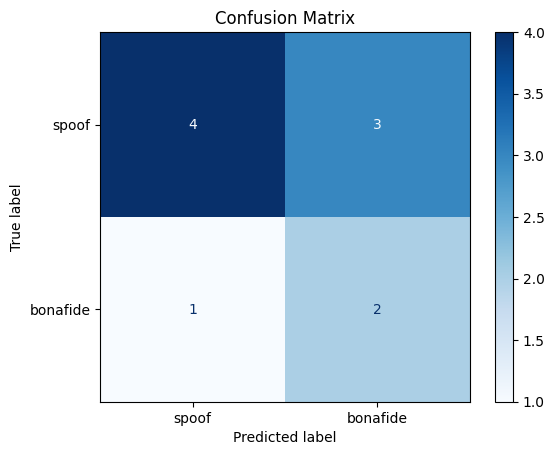

In [71]:
# CONFUSION MATRIX

cm = confusion_matrix(y_true, y_pred_classes)
classes = ["spoof", "bonafide"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


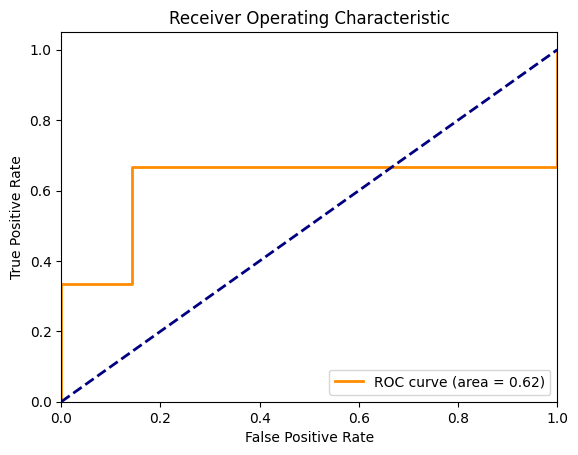

In [37]:
# ROC Curve

from sklearn.metrics import roc_curve, auc

y_pred = model.predict(X_test)
y_pred_prob = y_pred[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

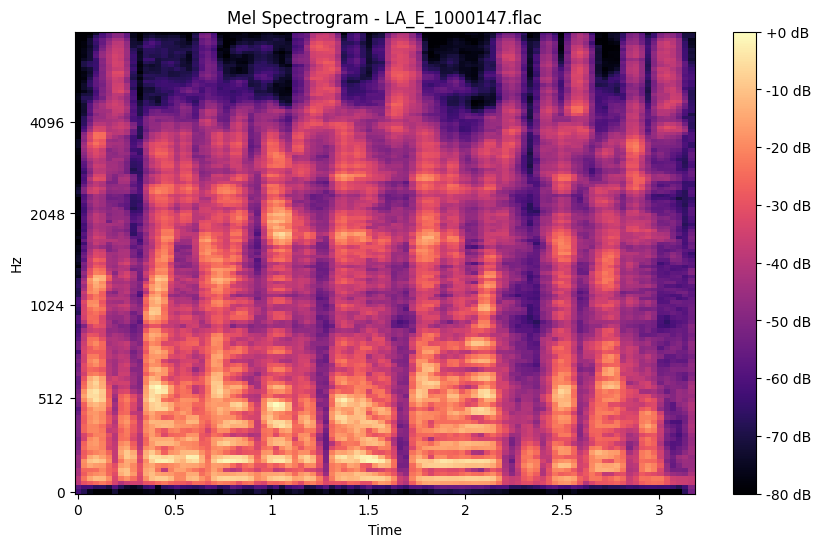

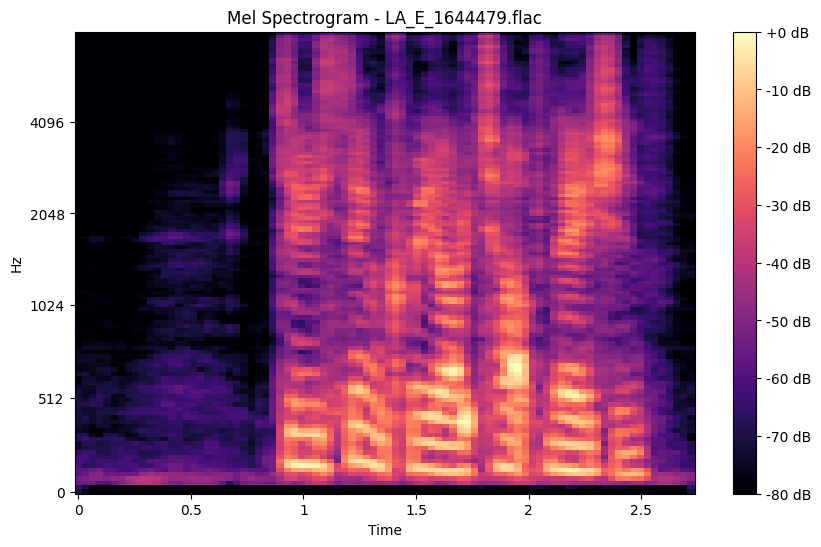

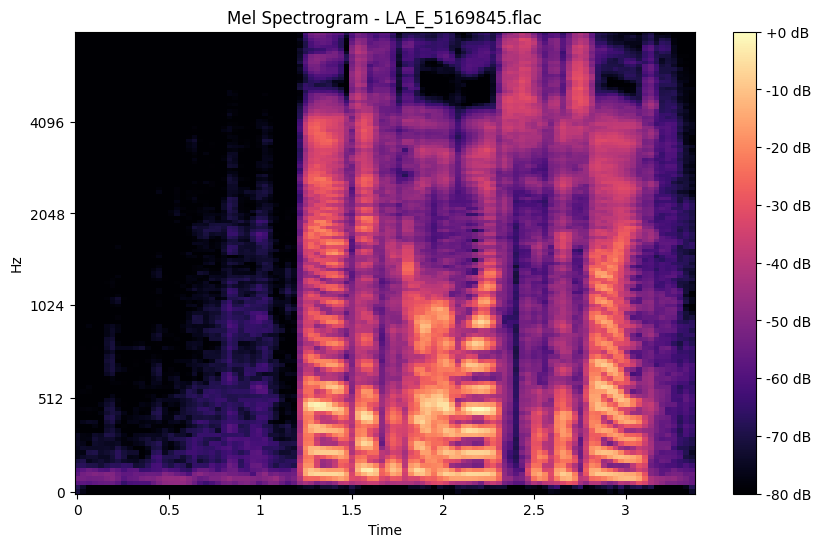

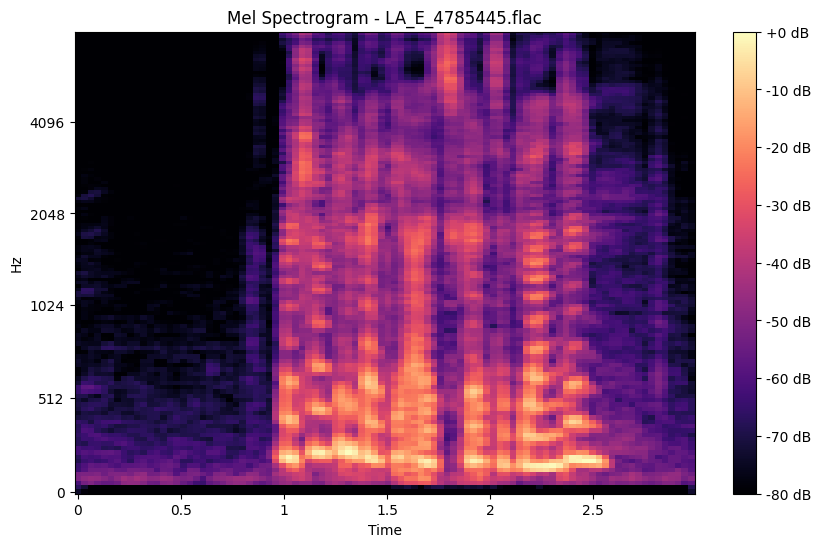

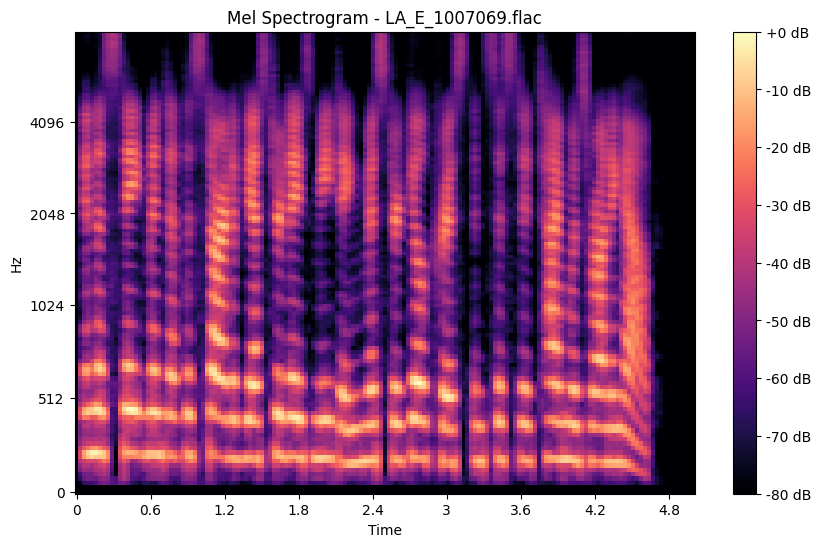

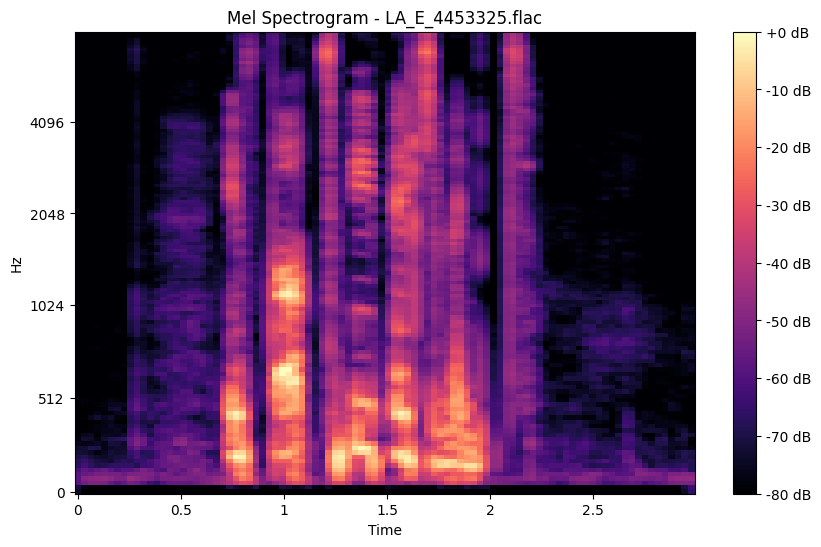

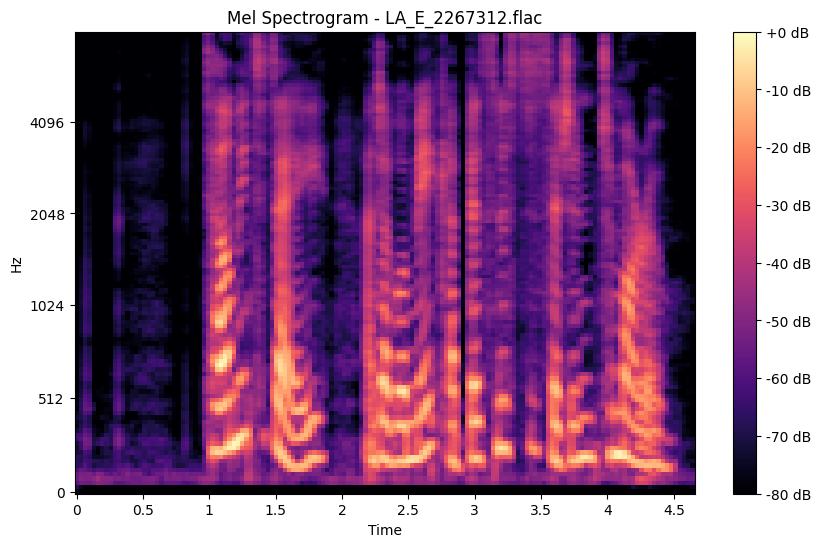

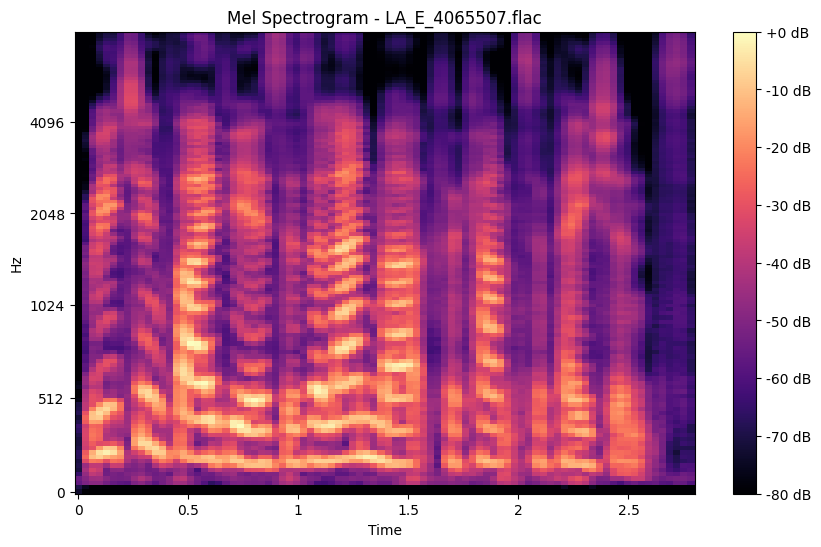

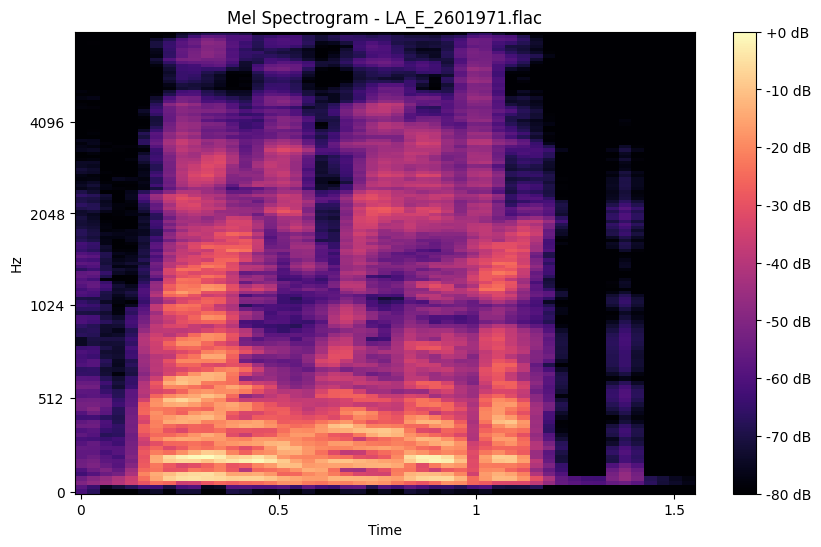

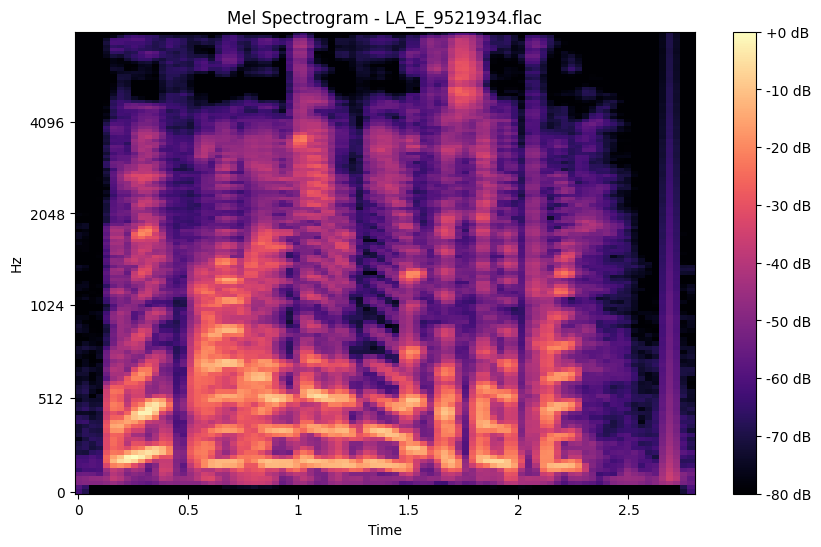

In [39]:
# Visualising Mel Spectrogram

import os
import librosa.display

# Folder containing .flac audio files
folder_path = "/content/drive/MyDrive/DL/CNNFakeAudioDetectionSpectrogramAnalysis/audio-deepfake-detection/TestEvaluation"

flac_files = [file for file in os.listdir(folder_path) if file.endswith(".flac")]

HOP_LENGTH = 512

# Loop through each .flac file and visualize its Mel spectrogram
for flac_file in flac_files:
    audio_file_path = os.path.join(folder_path, flac_file)

    audio, _ = librosa.load(audio_file_path, sr=SAMPLE_RATE, duration=DURATION)

    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='mel', sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram - {flac_file}')
    plt.show()


In [40]:
!pip install graphviz pydot

In [44]:
from tensorflow.keras.models import load_model

mod = load_model("/content/audio_classifier.h5")


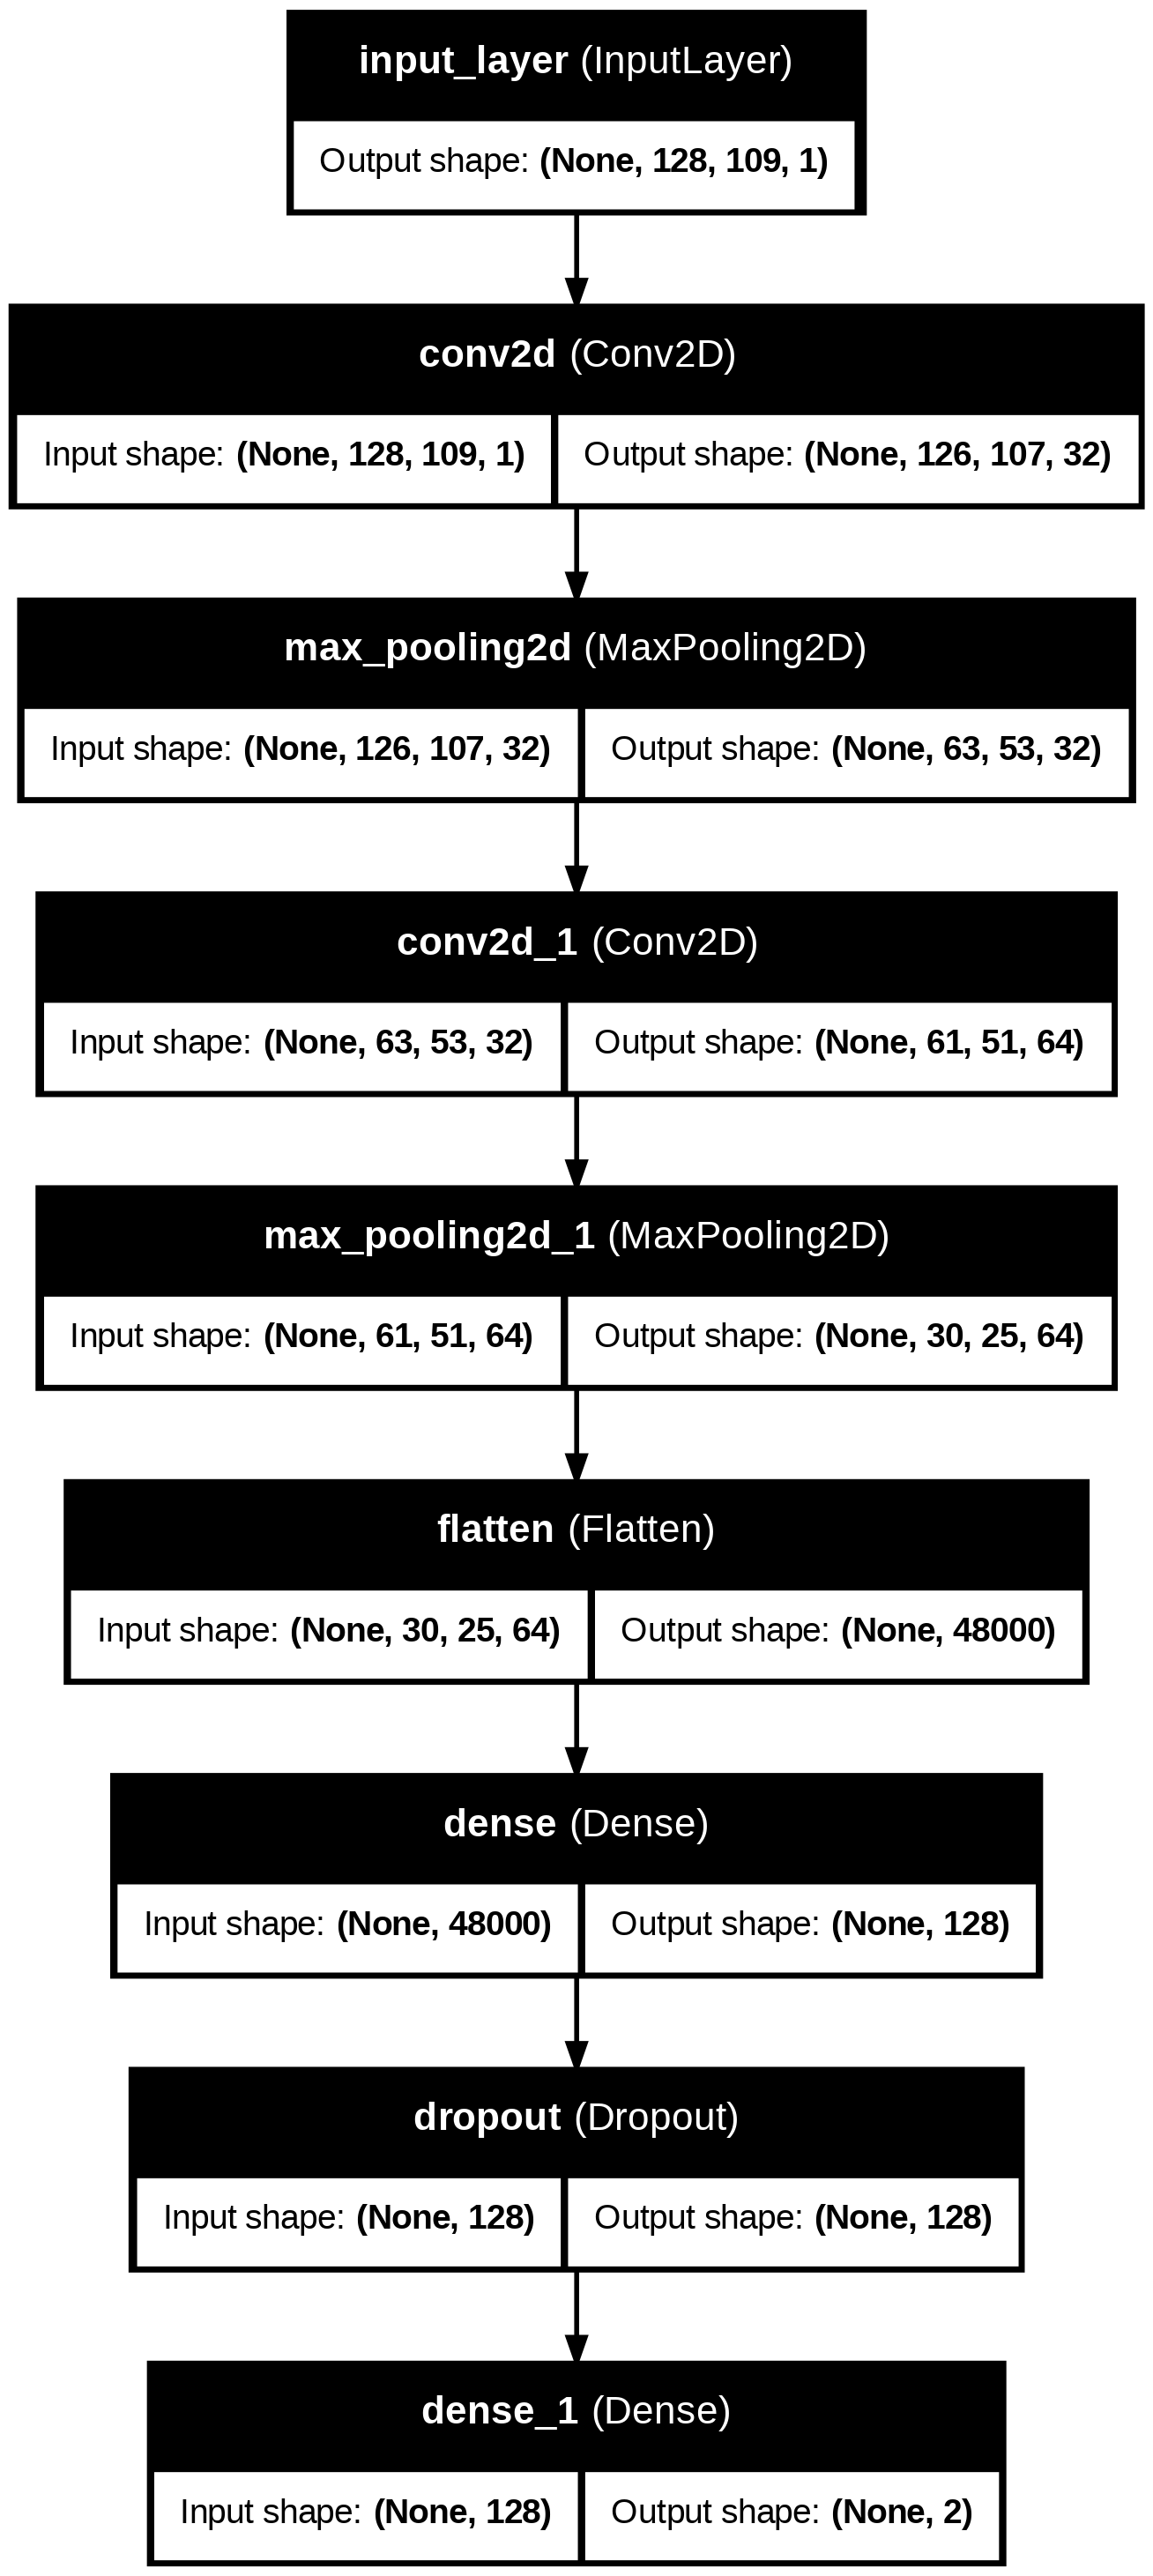

In [45]:
plot_model(mod, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)